In [1]:


import lettuce as lt
from lettuce import D3Q19, UnitConversion
import csv
from lettuce.util.moments import D3Q19ChavezTransform
from lettuce import Observable
from lettuce.ext._force.adaptive_force import AdaptiveForce
from lettuce.ext._boundary.wallfunction import WallFunction
from lettuce.ext._reporter.observable_reporter import GlobalMeanUXReporter, WallQuantities
from lettuce.ext._stencil.d3q19 import D3Q19


In [2]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import numpy as np
import torch

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=1)
parser.add_argument("--Re", type=int, default=180)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.1)
parser.add_argument("--h", type=int, default=20, help="Halbe Kanalhöhe in LU")
parser.add_argument("--bbtype", type=str, default="wallfunction", choices=["halfway", "fullway", "wallfunction", "freeslip"],
                    help="Typ der Bounce-Back-Randbedingung")

args, unknown = parser.parse_known_args()
args = vars(args)

print("ICH FUNKTIONIERE MIT PULLEN")



# Einheiten und Auflösung
h = args["h"]                      # Kanalhalbhöhe in LU
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)
res_z = int(np.pi * h)

# Restliche Parameter
Re = args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision = args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
bbtype = args["bbtype"]
h = args["h"]

# Präzision
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16


ICH FUNKTIONIERE MIT PULLEN


In [3]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=dtype, use_native = False)

flow = lt.ChannelFlow3D(
    context = context,
    resolution=h,
    reynolds_number=6432 if Re == 180 else Re**(8/7)*(8/0.073)**(4/7),
    stencil = D3Q19(),
    mach_number=Mach,
    bbtype=bbtype
)

shape = flow.resolution
mask_bottom = torch.zeros(shape, dtype=torch.bool, device=context.device)
mask_bottom[:, 0, :] = True
mask_top = torch.zeros(shape, dtype=torch.bool, device=context.device)
mask_top[:, -1, :] = True
mask_force = torch.ones(shape, dtype=torch.bool, device=context.device)
mask_force[:, 0, :] = False
mask_force[:, -1, :] = False

global_mean_ux_reporter = GlobalMeanUXReporter(flow = flow)

wq_bottom = WallQuantities(mask = mask_bottom, wall = "bottom", flow=flow, boundary=flow.boundaries[0], context = context)
wq_top = WallQuantities(mask = mask_top, wall = "top", flow=flow, boundary=flow.boundaries[1], context = context)

adaptive_force_instance = AdaptiveForce(
    flow=flow,
    context = context,
    target_u_m_lu=flow.units.convert_velocity_to_lu(1),
    wall_bottom=flow.boundaries[0],
    wall_top=flow.boundaries[1],
    global_ux_reporter=global_mean_ux_reporter,
    base_lbm_tau_lu=flow.units.relaxation_parameter_lu,
    mask = mask_force
)

if collision_operator == "BGK":

    collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)

elif collision_operator == "Smag":
    
    collision = lt.SmagorinskyCollision(tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)

elif collision_operator == "MRT":
    
    relaxation_parameters = [
    0.0,  # s0  -> Dichte
    0.0,  # s1  -> jx
    0.0,  # s2  -> jy
    0.0,  # s3  -> jz
    1.6,  # s4  -> pxy
    1.6,  # s5  -> pxz
    1.6,  # s6  -> pyz
    1.8,  # s7  -> pww
    1.8,  # s8  -> 3pxx
    1.8,  # s9  -> e
    1.2,  # s10 -> qx
    1.2,  # s11 -> qy
    1.2,  # s12 -> qz
    1.98, # s13 -> mx
    1.98, # s14 -> my
    1.98, # s15 -> mz
    1.4,  # s16 -> 3xx
    1.4,  # s17 -> ww
    1.4,  # s18 -> eps
]

    collision = lt.MRTCollision(transform = D3Q19ChavezTransform(stencil = flow.stencil, context = context), relaxation_parameters=relaxation_parameters, context=context, force=adaptive_force_instance)

simulation = lt.Simulation(flow=flow, collision=collision, reporter = [])

simulation.reporter.append(lt.ObservableReporter(global_mean_ux_reporter, interval=1, out=None))
simulation.reporter.append(lt.ObservableReporter(wq_bottom, interval=100, out=None))
simulation.reporter.append(lt.ObservableReporter(wq_top, interval=100, out=None))

steps = int(flow.units.convert_time_to_lu(tmax))
vtk_reporter = lt.VTKReporter(interval=max(1, int(steps/100)), filename_base=basedir + "/output_h20_t30")
simulation.reporter.append(vtk_reporter)

mlups = simulation.step(num_steps=steps)

wq_top_arr = np.array(simulation.reporter[2].out)
wq_bottom_arr = np.array(simulation.reporter[1].out)
ux_mean_arr = np.array(simulation.reporter[0].out)

with open(csvdir + 'uxmean.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ux_mean_arr)
with open(csvdir + 'WallQuantitiesTop.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_top_arr)
with open(csvdir + 'WallQuantitiesBottom.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_bottom_arr)


[125, 40, 62] 19
y+: 5 Re_tau: 117
y+: 4 Re_tau: 89
y+: 4 Re_tau: 92
y+: 4 Re_tau: 96
y+: 4 Re_tau: 97
y+: 4 Re_tau: 96
y+: 4 Re_tau: 99
y+: 4 Re_tau: 95
y+: 4 Re_tau: 99
y+: 4 Re_tau: 95
y+: 5 Re_tau: 100
y+: 4 Re_tau: 97
y+: 5 Re_tau: 101
y+: 4 Re_tau: 98
y+: 5 Re_tau: 100
y+: 4 Re_tau: 99
y+: 5 Re_tau: 103
y+: 5 Re_tau: 100
y+: 5 Re_tau: 104
y+: 5 Re_tau: 101
y+: 5 Re_tau: 104
y+: 5 Re_tau: 102
y+: 5 Re_tau: 105
y+: 5 Re_tau: 103
y+: 5 Re_tau: 106
y+: 5 Re_tau: 103
y+: 5 Re_tau: 106
y+: 5 Re_tau: 104
y+: 5 Re_tau: 107
y+: 5 Re_tau: 105
y+: 5 Re_tau: 107
y+: 5 Re_tau: 105
y+: 5 Re_tau: 108
y+: 5 Re_tau: 106
y+: 5 Re_tau: 108
y+: 5 Re_tau: 106
y+: 5 Re_tau: 109
y+: 5 Re_tau: 107
y+: 5 Re_tau: 109
y+: 5 Re_tau: 108
y+: 5 Re_tau: 110
y+: 5 Re_tau: 109
y+: 5 Re_tau: 111
y+: 5 Re_tau: 109
y+: 5 Re_tau: 111
y+: 5 Re_tau: 110
y+: 5 Re_tau: 112
y+: 5 Re_tau: 110
y+: 5 Re_tau: 112
y+: 5 Re_tau: 111
y+: 5 Re_tau: 112
y+: 5 Re_tau: 110
y+: 5 Re_tau: 112
y+: 5 Re_tau: 110
y+: 5 Re_tau: 112
y+: 5

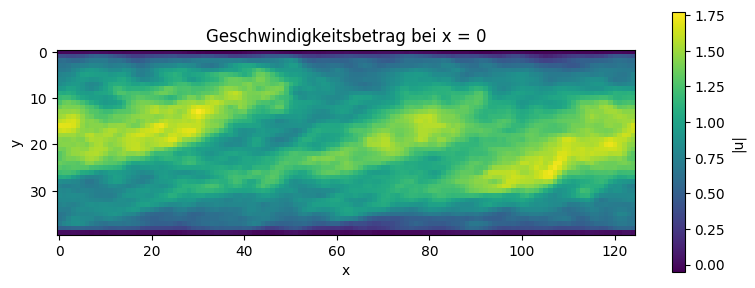

In [4]:
import matplotlib.pyplot as plt
# 💡 Schritt 1: u holen und Betrag berechnen
u = flow.units.convert_velocity_to_pu(flow.u())  # [3, Nx, Ny, Nz]
u_mag = torch.sqrt(u[0]**2+u[2]**2)  # [Nx, Ny, Nz]
u_mag = u[0]
# 💡 Schritt 2: Slice bei x = 0 extrahieren
slice_2d = np.transpose(u_mag[:, :, 0])  # [Ny, Nz]

# 💡 Schritt 3: Plotten
plt.figure(figsize=(8, 3))
plt.imshow(slice_2d.cpu().numpy())
plt.colorbar(label='|u|')
plt.title('Geschwindigkeitsbetrag bei x = 0')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig(csvdir + "u.pdf")
plt.show()


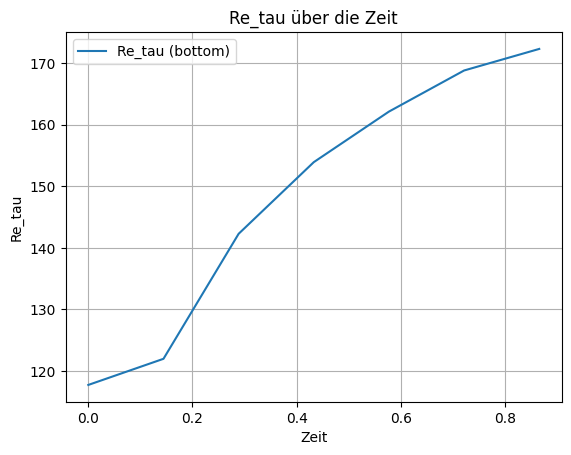

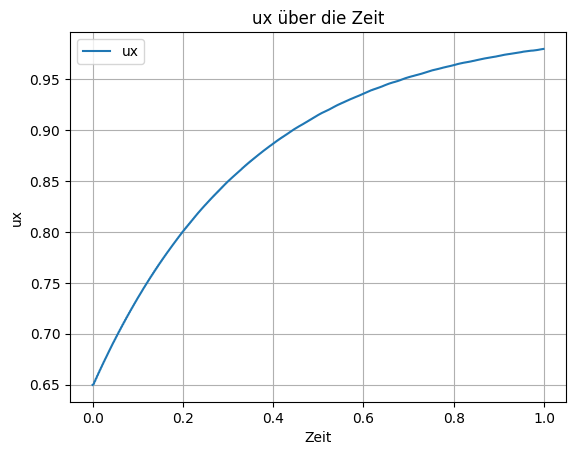

In [5]:



print(wq_bottom)
# Beispiel: Daten laden
data = (wq_bottom_arr+wq_top_arr)/2
time = data[:, 1]
re_tau = data[:, 4]
y_plus = data[:, 3]


plt.figure()
plt.plot(time, re_tau, label="Re_tau (bottom)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.savefig(csvdir + "retau.pdf")

plt.show()

plt.figure()
plt.plot(ux_mean_arr[:,1], flow.units.convert_velocity_to_pu(ux_mean_arr[:,2]), label="ux")
plt.xlabel("Zeit")
plt.ylabel("ux")
plt.legend()
plt.grid()
plt.title("ux über die Zeit")
plt.savefig(csvdir + "yplus.pdf")
plt.show()


In [6]:
print(u.shape)

torch.Size([3, 125, 40, 62])


In [7]:
import numpy as np

def viscosity_loglaw(Re_tau, uB=0.111, Lz=4.0, kappa=0.41, A=5.2):
    factor = (1 / kappa) * np.log(Re_tau) + A
    nu = (uB * Lz) / (2 * Re_tau * factor)
    return nu

def reynolds_number(char_length, char_velocity, viscosity):
    return char_length * char_velocity / viscosity

# Vorgaben
Re_tau = 180
uB = 1  # m/s
Lz = 1
H = "hi"     # Kanalhalbhöhe
L = 2 * H   # Kanalhöhe = 1.0

# Schritt 1: Viskosität berechnen
nu = viscosity_loglaw(Re_tau, uB=uB, Lz=Lz)
print(f"Viskosität (ν): {nu:.6e} m²/s")

# Schritt 2: Re klassisch berechnen
Re = reynolds_number(Lz, uB, nu)
print(f"Re = {Re:.2f}")


Viskosität (ν): 1.554806e-04 m²/s
Re = 6431.67


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def plot_mean_velocity_profile(flow, plot_yplus=True, loglaw=True):
    """
    Plottet das mittlere Geschwindigkeitsprofil u_x(y) über die Kanalhöhe.

    Parameter:
    -----------
    flow : Flow-Objekt (z. B. ChannelFlow3D)
        Muss bereits eine Simulation enthalten.
    plot_yplus : bool
        Falls True, wird das Profil zusätzlich in y⁺/u⁺ dargestellt.
    loglaw : bool
        Falls True, wird das klassische Log-Law-Profil (u⁺ = (1/κ) log(y⁺) + B) mit geplottet.
    """

    # --- 1. Geschwindigkeit holen und u_x extrahieren
    u = flow.units.convert_velocity_to_pu(flow.u())  # [3, Nx, Ny, Nz] in physikalischen Einheiten
    ux = u[0]  # [Nx, Ny, Nz]

    # --- 2. Mittelung über x- und z-Richtung: ⟨u_x⟩(y)
    ux_mean_y = ux.mean(dim=(0, 2))  # → [Ny]

    # --- 3. y-Koordinaten in PU erzeugen
    Ny = flow.resolution[1]
    y_lu = torch.arange(Ny, device=flow.context.device)
    y_pu = flow.units.convert_length_to_pu(y_lu)

    # --- 4. Plot in physikalischen Einheiten
    plt.figure(figsize=(6, 4))
    plt.plot(y_pu.cpu(), ux_mean_y.cpu(), label=r'$\langle u_x \rangle(y)$ [m/s]')
    plt.xlabel("Höhe y [PU]")
    plt.ylabel(r"$\langle u_x \rangle$ [m/s]")
    plt.title("Mittlere x-Geschwindigkeit über Kanalhöhe")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Optional: Wandkoordinaten (y⁺) und u⁺-Profil
    if plot_yplus:
        try:
            u_tau = flow.reporters["WallQuantities"].u_tau_mean
        except (KeyError, AttributeError):
            raise RuntimeError("Kein u_tau verfügbar! Stelle sicher, dass ein WallQuantities-Reporter vorhanden ist.")

        nu = flow.units.nu_pu
        y_plus = y_pu * u_tau / nu
        u_plus = ux_mean_y / u_tau

        # --- Optional: Log-Law-Profil zum Vergleich
        if loglaw:
            y_plus_log = np.linspace(30, y_plus.max().cpu().item(), 500)
            kappa = 0.41
            B = 5.2
            u_plus_log = (1 / kappa) * np.log(y_plus_log) + B

        # --- Plot in wandskalierten Einheiten
        plt.figure(figsize=(6, 4))
        plt.plot(y_plus.cpu(), u_plus.cpu(), label=r'$u^+(y^+)$')
        if loglaw:
            plt.plot(y_plus_log, u_plus_log, '--', label='Log-law')
        plt.xlabel(r"$y^+$")
        plt.ylabel(r"$u^+$")
        plt.title("Mittlere Geschwindigkeit in wandskalierten Einheiten")
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.xscale("log")
        plt.show()


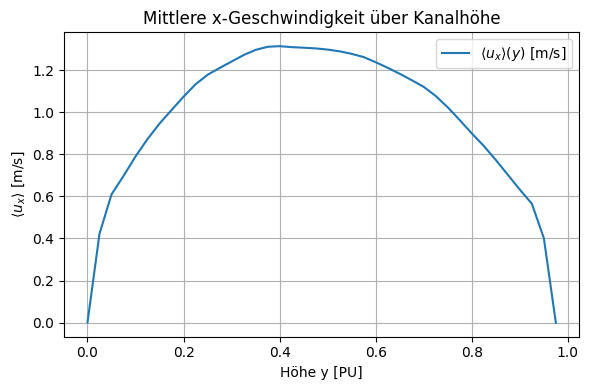

RuntimeError: Kein u_tau verfügbar! Stelle sicher, dass ein WallQuantities-Reporter vorhanden ist.

In [9]:
plot_mean_velocity_profile(flow, plot_yplus=True)


In [ ]:
#